In [1]:
import copy
import torch.optim.lr_scheduler
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from create_translate_data import create_dateset, truncate_pad
from util import *
from attention import *

In [3]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        self.layer1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.layer2(self.relu(self.layer1(X)))

In [4]:
class AddNorm(nn.Module):
    def __init__(self, shape, dropout, use_bias=False):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shape)
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(shape))

    def forward(self, X, Y):
        if self.use_bias:
            return self.layer_norm(X + Y + self.bias)
        else:
            return self.layer_norm(X + self.dropout(Y))

In [5]:
class AddNorm_no_ln(nn.Module):
    def __init__(self, shape, dropout, use_bias=False):
        super(AddNorm_no_ln, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shape)
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(shape))

    def forward(self, X, Y):
        if self.use_bias:
            return X + Y + self.bias
        else:
            return X + self.dropout(Y)

In [6]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout, use_bias)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# X = torch.ones((2, 100, 24))
# valid_lens = torch.tensor([3, 2])
# encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
# encoder_blk.eval()

In [7]:
class EncoderBlock_no_ln(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super(EncoderBlock_no_ln, self).__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm_no_ln(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm_no_ln(norm_shape, dropout, use_bias)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# X = torch.ones((2, 100, 24))
# valid_lens = torch.tensor([3, 2])
# encoder_blk = EncoderBlock_no_ln(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
# encoder_blk.eval()

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerEncoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("encoder_blk_%d" % i, EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X


# encoder = TransformerEncoder(
#     200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# encoder.eval()

In [9]:
class TransformerEncoder_no_ln(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerEncoder_no_ln, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("encoder_blk_%d" % i, EncoderBlock_no_ln(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X


# encoder = TransformerEncoder(
#     200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# encoder.eval()

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, i, use_bias=False):
        super(DecoderBlock, self).__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout, use_bias)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout, use_bias)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        batch_size, num_steps, _ = X.shape
        dec_valid_lens = torch.arange(
            1, num_steps + 1, device=X.device).repeat(batch_size, 1)

        X2 = self.attention1(X, X, X, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [11]:
class DecoderBlock_no_ln(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, i, use_bias=False):
        super(DecoderBlock_no_ln, self).__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm_no_ln(norm_shape, dropout, use_bias)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm_no_ln(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm_no_ln(norm_shape, dropout, use_bias)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        batch_size, num_steps, _ = X.shape
        dec_valid_lens = torch.arange(
            1, num_steps + 1, device=X.device).repeat(batch_size, 1)

        X2 = self.attention1(X, X, X, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [12]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerDecoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("decoder_blk_%d" % i, DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, i, use_bias))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        self.seqX = None
        return [enc_outputs, enc_valid_lens]

    def forward(self, X, state):
        if not self.training:
            self.seqX = X if self.seqX is None else torch.cat((self.seqX, X), dim=1)
            X = self.seqX

        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights

        if not self.training:
            return self.dense(X)[:, -1:, :], state

        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [13]:
class TransformerDecoder_no_ln(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerDecoder_no_ln, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("decoder_blk_%d" % i, DecoderBlock_no_ln(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, i, use_bias))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        self.seqX = None
        return [enc_outputs, enc_valid_lens]

    def forward(self, X, state):
        if not self.training:
            self.seqX = X if self.seqX is None else torch.cat((self.seqX, X), dim=1)
            X = self.seqX

        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights

        if not self.training:
            return self.dense(X)[:, -1:, :], state

        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, enc_valid_lens):
        enc_outputs = self.encoder(enc_X, enc_valid_lens)
        dec_state = self.decoder.init_state(enc_outputs, enc_valid_lens)
        return self.decoder(dec_X, dec_state)

In [15]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 60
num_epochs = 1000
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
corpus_size = 1000
key_size, query_size, value_size = 32, 32, 32
norm_shape = [num_hiddens]
en_file = 'en-de/train.en-de.low.filt.en'
de_file = 'en-de/train.en-de.low.filt.de'
data_iter, input_vocab, target_vocab = create_dateset(en_file, de_file, corpus_size, 2, 10, device, batch_size)
loss = MaskedSoftmaxCELoss()


In [16]:
acc_test_input = []
test_files_input = open(en_file, 'r', encoding='UTF-8')
line = test_files_input.readline().strip().split()
acc_test_input.append(' '.join(line[:20]))
for i in range(99):
    line = test_files_input.readline().strip().split()
    if len(line) > 20:
        acc_test_input.append(' '.join(line[:20]))
    else:
        acc_test_input.append(' '.join(line))
test_files_input.close()

In [17]:
acc_test_input

["with vibrant video clips captured by submarines , david gallo takes us to some of earth 's darkest , most",
 "david gallo : this is bill lange . i 'm dave gallo .",
 "and we 're going to tell you some stories from the sea here in video .",
 "we 've got some of the most incredible video of titanic that 's ever been seen , and we 're",
 "the truth of the matter is that the titanic -- even though it 's breaking all sorts of box office",
 'and the problem , i think , is that we take the ocean for granted .',
 'when you think about it , the oceans are 75 percent of the planet .',
 'most of the planet is ocean water .',
 'the average depth is about two miles .',
 'part of the problem , i think , is we stand at the beach , or we see images like',
 'and in the oceans , there are the longest mountain ranges on the planet .',
 'most of the animals are in the oceans .',
 'most of the earthquakes and volcanoes are in the sea , at the bottom of the sea .',
 'the biodiversity and the biodensity in

In [18]:
acc_test_target = []
test_files_target = open(de_file, 'r', encoding='UTF-8')
line = test_files_target.readline().strip().split()
acc_test_target.append(line[:20])
for i in range(99):
    line = test_files_target.readline().strip().split()
    if len(line) > 20:
        acc_test_target.append(line[:20])
    else:
        acc_test_target.append(line)
test_files_target.close()

In [19]:
acc_test_target

[['mit',
  'hilfe',
  'von',
  'lebendigen',
  'videos',
  ',',
  'die',
  'von',
  'unterseebooten',
  'gemacht',
  'wurden',
  ',',
  'führt',
  'uns',
  'david',
  'gallo',
  'zu',
  'den',
  'dunkelsten',
  ','],
 ['david',
  'gallo',
  ':',
  'das',
  'ist',
  'bill',
  'lange',
  '.',
  'ich',
  'bin',
  'dave',
  'gallo',
  '.'],
 ['wir',
  'werden',
  'ihnen',
  'einige',
  'geschichten',
  'über',
  'das',
  'meer',
  'in',
  'videoform',
  'erzählen',
  '.'],
 ['wir',
  'haben',
  'ein',
  'paar',
  'der',
  'unglaublichsten',
  'aufnahmen',
  'der',
  'titanic',
  ',',
  'die',
  'man',
  'je',
  'gesehen',
  'hat',
  ',',
  ',',
  'und',
  'wir',
  'werden'],
 ['die',
  'wahrheit',
  'ist',
  ',',
  'dass',
  'die',
  'titanic',
  '–',
  'obwohl',
  'sie',
  'alle',
  'kinokassenrekorde',
  'bricht',
  '–',
  'nicht',
  'gerade',
  'die',
  'aufregendste',
  'geschichte',
  'vom'],
 ['ich',
  'denke',
  ',',
  'das',
  'problem',
  'ist',
  ',',
  'dass',
  'wir',
  'das',


In [20]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [21]:
def predict_seq2seq_beam(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, k=3, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    max_prob = -float('inf')
    max_output_seq, max_attention_weight_seq = [], []
    # beam first step, pick top 3
    Y, dec_state = net.decoder(dec_X, dec_state)
    top_dec_X = torch.topk(Y, k=k, dim=2)
    for i in top_dec_X[0].to(torch.long).permute(2, 0, 1):
        curr_prob = i
        dec_X = i
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        for _ in range(1, num_steps):
            Y, dec_state = net.decoder(dec_X, dec_state)
            dec_X = Y.argmax(dim=2)
            pred = dec_X.squeeze(dim=0).type(torch.int32).item()
            if save_attention_weights:
                attention_weight_seq.append(net.decoder.attention_weights)
            if pred == tgt_vocab['<eos>']:
                break
            output_seq.append(pred)
        if curr_prob.float() > max_prob:
            max_prob = curr_prob
            max_output_seq = output_seq
            max_attention_weight_seq = attention_weight_seq
        output_seq, attention_weight_seq = [], []

    return ' '.join(tgt_vocab.to_tokens(max_output_seq)), max_attention_weight_seq

In [22]:
def train_transformer(model, num_epochs, data_iter, optimizer, scheduler):
    best_loss = float('inf')
    # learning_curve = [np.nan] * (num_epochs//10+1)
    # bleu_scores = [np.nan] * (num_epochs//10+1)
    # losses_list = []
    grads = []
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        model.train()
        grad = []
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([target_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
            grad.append(model.decoder.dense.weight.grad.cpu().clone())
        # if epoch == 0:
        #     learning_curve[0] = metric[0] / metric[1]
        #     model.eval()
        #     bleu_scores[0] = 0
        #     for sent in range(len(acc_test_input)):
        #         target_len = len(acc_test_target[sent])
        #         pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
        #         bleu_scores[0] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
        # losses_list.append(metric[0] / metric[1])
        grads.append(grad)
        if (epoch + 1) % 10 == 0:
            print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            print("Loss: {:.4f}".format((metric[0] / metric[1])))
            # learning_curve[(epoch+1)//10] = metric[0] / metric[1]
            # model.eval()
            # bleu_scores[(epoch+1)//10] = 0
            # for sent in range(len(acc_test_input)):
            #     target_len = len(acc_test_target[sent])
            #     pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
            #     bleu_scores[(epoch+1)//10] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
            # print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            # print("Bleu: {:.4f}".format(bleu_scores[(epoch+1)//10]))

        if (metric[0] / metric[1]) < best_loss:
            best_loss = (metric[0] / metric[1])
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, 'transformer_weights_'+str(corpus_size)+'_sentences_' +
                       str(num_epochs)+'_epochs.pth')
        scheduler.step()

    return grads

In [23]:
def train_transformer_no_ln(model, num_epochs, data_iter, optimizer, scheduler):
    best_loss = float('inf')
    # learning_curve = [np.nan] * (num_epochs//10+1)
    # bleu_scores = [np.nan] * (num_epochs//10+1)
    # losses_list = []
    grads = []
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        model.train()
        grad = []
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([target_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
            grad.append(model.decoder.dense.weight.grad.cpu().clone())
        # if epoch == 0:
        #     learning_curve[0] = metric[0] / metric[1]
        #     model.eval()
        #     bleu_scores[0] = 0
        #     for sent in range(len(acc_test_input)):
        #         target_len = len(acc_test_target[sent])
        #         pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
        #         bleu_scores[0] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
        # losses_list.append(metric[0] / metric[1])
        grads.append(grad)
        if (epoch + 1) % 10 == 0:
            print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            print("Loss: {:.4f}".format((metric[0] / metric[1])))
            # learning_curve[(epoch+1)//10] = metric[0] / metric[1]
            # model.eval()
            # bleu_scores[(epoch+1)//10] = 0
            # for sent in range(len(acc_test_input)):
            #     target_len = len(acc_test_target[sent])
            #     pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
            #     bleu_scores[(epoch+1)//10] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
            # print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            # print("Bleu: {:.4f}".format(bleu_scores[(epoch+1)//10]))

        if (metric[0] / metric[1]) < best_loss:
            best_loss = (metric[0] / metric[1])
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, 'transformer_no_ln_weights_'+str(corpus_size)+'_sentences_' +
                       str(num_epochs)+'_epochs.pth')
        scheduler.step()

    return grads

In [24]:
training_results = {}

In [25]:
lr = 0.003
encoder = TransformerEncoder(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[num_epochs//5, num_epochs*2//5,
                                                                        num_epochs*3//5, num_epochs*4//5], gamma=0.9)
grads_layer_03 = train_transformer(model, num_epochs, data_iter, optimizer, scheduler)

Epoch: 10/1000............. Loss: 0.4304
Epoch: 20/1000............. Loss: 0.3443
Epoch: 30/1000............. Loss: 0.2866
Epoch: 40/1000............. Loss: 0.2448
Epoch: 50/1000............. Loss: 0.2173
Epoch: 60/1000............. Loss: 0.1962
Epoch: 70/1000............. Loss: 0.1763
Epoch: 80/1000............. Loss: 0.1656
Epoch: 90/1000............. Loss: 0.1526
Epoch: 100/1000............. Loss: 0.1415
Epoch: 110/1000............. Loss: 0.1353
Epoch: 120/1000............. Loss: 0.1274
Epoch: 130/1000............. Loss: 0.1216
Epoch: 140/1000............. Loss: 0.1155
Epoch: 150/1000............. Loss: 0.1110
Epoch: 160/1000............. Loss: 0.1077
Epoch: 170/1000............. Loss: 0.1050
Epoch: 180/1000............. Loss: 0.1011
Epoch: 190/1000............. Loss: 0.0936
Epoch: 200/1000............. Loss: 0.0925
Epoch: 210/1000............. Loss: 0.0907
Epoch: 220/1000............. Loss: 0.0858
Epoch: 230/1000............. Loss: 0.0843
Epoch: 240/1000............. Loss: 0.0820
E

In [26]:
# model.load_state_dict(torch.load('transformer_weights_'+str(corpus_size)+'_sentences_' + str(num_epochs)+'_epochs.pth'))
# model.eval()

In [27]:
lr = 0.003
encoder = TransformerEncoder_no_ln(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder_no_ln(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[num_epochs//5, num_epochs*2//5,
                                                                                num_epochs*3//5, num_epochs*4//5], gamma=0.9)
grads_no_layer_03 = train_transformer_no_ln(model, num_epochs, data_iter, optimizer, scheduler)

Epoch: 10/1000............. Loss: 0.4041
Epoch: 20/1000............. Loss: 0.3470
Epoch: 30/1000............. Loss: 0.3182
Epoch: 40/1000............. Loss: 0.2994
Epoch: 50/1000............. Loss: 0.2831
Epoch: 60/1000............. Loss: 0.2731
Epoch: 70/1000............. Loss: 0.2644
Epoch: 80/1000............. Loss: 0.2596
Epoch: 90/1000............. Loss: 0.2504
Epoch: 100/1000............. Loss: 0.2449
Epoch: 110/1000............. Loss: 0.2429
Epoch: 120/1000............. Loss: 0.2383
Epoch: 130/1000............. Loss: 0.2351
Epoch: 140/1000............. Loss: 0.2299
Epoch: 150/1000............. Loss: 0.2278
Epoch: 160/1000............. Loss: 0.2258
Epoch: 170/1000............. Loss: 0.2211
Epoch: 180/1000............. Loss: 0.2183
Epoch: 190/1000............. Loss: 0.2199
Epoch: 200/1000............. Loss: 0.2151
Epoch: 210/1000............. Loss: 0.2113
Epoch: 220/1000............. Loss: 0.2086
Epoch: 230/1000............. Loss: 0.2093
Epoch: 240/1000............. Loss: 0.2085
E

In [28]:
lr = 0.0008
encoder = TransformerEncoder(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[num_epochs//5, num_epochs*2//5,
                                                                        num_epochs*3//5, num_epochs*4//5], gamma=0.9)
grads_layer_006 = train_transformer(model, num_epochs, data_iter, optimizer, scheduler)

Epoch: 10/1000............. Loss: 0.5120
Epoch: 20/1000............. Loss: 0.4659
Epoch: 30/1000............. Loss: 0.4310
Epoch: 40/1000............. Loss: 0.4024
Epoch: 50/1000............. Loss: 0.3770
Epoch: 60/1000............. Loss: 0.3547
Epoch: 70/1000............. Loss: 0.3331
Epoch: 80/1000............. Loss: 0.3160
Epoch: 90/1000............. Loss: 0.2988
Epoch: 100/1000............. Loss: 0.2835
Epoch: 110/1000............. Loss: 0.2687
Epoch: 120/1000............. Loss: 0.2566
Epoch: 130/1000............. Loss: 0.2444
Epoch: 140/1000............. Loss: 0.2354
Epoch: 150/1000............. Loss: 0.2246
Epoch: 160/1000............. Loss: 0.2158
Epoch: 170/1000............. Loss: 0.2074
Epoch: 180/1000............. Loss: 0.2010
Epoch: 190/1000............. Loss: 0.1936
Epoch: 200/1000............. Loss: 0.1871
Epoch: 210/1000............. Loss: 0.1814
Epoch: 220/1000............. Loss: 0.1768
Epoch: 230/1000............. Loss: 0.1710
Epoch: 240/1000............. Loss: 0.1680
E

In [29]:
lr = 0.0008
encoder = TransformerEncoder_no_ln(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                                   ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder_no_ln(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                                   ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[num_epochs//5, num_epochs*2//5,
                                                                        num_epochs*3//5, num_epochs*4//5], gamma=0.9)
grads_no_layer_006 = train_transformer_no_ln(model, num_epochs, data_iter, optimizer, scheduler)

Epoch: 10/1000............. Loss: 0.5119
Epoch: 20/1000............. Loss: 0.4426
Epoch: 30/1000............. Loss: 0.3996
Epoch: 40/1000............. Loss: 0.3738
Epoch: 50/1000............. Loss: 0.3523
Epoch: 60/1000............. Loss: 0.3347
Epoch: 70/1000............. Loss: 0.3215
Epoch: 80/1000............. Loss: 0.3110
Epoch: 90/1000............. Loss: 0.3004
Epoch: 100/1000............. Loss: 0.2904
Epoch: 110/1000............. Loss: 0.2832
Epoch: 120/1000............. Loss: 0.2768
Epoch: 130/1000............. Loss: 0.2678
Epoch: 140/1000............. Loss: 0.2621
Epoch: 150/1000............. Loss: 0.2550
Epoch: 160/1000............. Loss: 0.2471
Epoch: 170/1000............. Loss: 0.2452
Epoch: 180/1000............. Loss: 0.2396
Epoch: 190/1000............. Loss: 0.2370
Epoch: 200/1000............. Loss: 0.2294
Epoch: 210/1000............. Loss: 0.2244
Epoch: 220/1000............. Loss: 0.2197
Epoch: 230/1000............. Loss: 0.2160
Epoch: 240/1000............. Loss: 0.2112
E

In [32]:
lol_no_layer_03 = np.array(grads_no_layer_03).flatten()
lol_layer_03 = np.array(grads_layer_03).flatten()
lol_no_layer_006 = np.array(grads_no_layer_006).flatten()
lol_layer_006 = np.array(grads_layer_006).flatten()

kek_no_layer_03 = []
kek_layer_03 = []
kek_no_layer_006 = []
kek_layer_006 = []
for i in range(1,len(lol_layer_03)):
    kek_no_layer_03.append((lol_no_layer_03[i-1] - lol_no_layer_03[i]).norm(p=2).item())
    kek_layer_03.append((lol_layer_03[i-1] - lol_layer_03[i]).norm(p=2).item())
    kek_no_layer_006.append((lol_no_layer_006[i-1] - lol_no_layer_006[i]).norm(p=2).item())
    kek_layer_006.append((lol_layer_006[i-1] - lol_layer_006[i]).norm(p=2).item())

min_no_layer_curve = []
max_no_layer_curve = []
min_layer_curve = []
max_layer_curve = []
for i in range(len(kek_layer_03)):
    min_no_layer_curve.append(np.min([kek_no_layer_03[i], kek_no_layer_006[i]]))
    max_no_layer_curve.append(np.max([kek_no_layer_03[i], kek_no_layer_006[i]]))
    min_layer_curve.append(np.min([kek_layer_03[i], kek_layer_006[i]]))
    max_layer_curve.append(np.max([kek_layer_03[i], kek_layer_006[i]]))


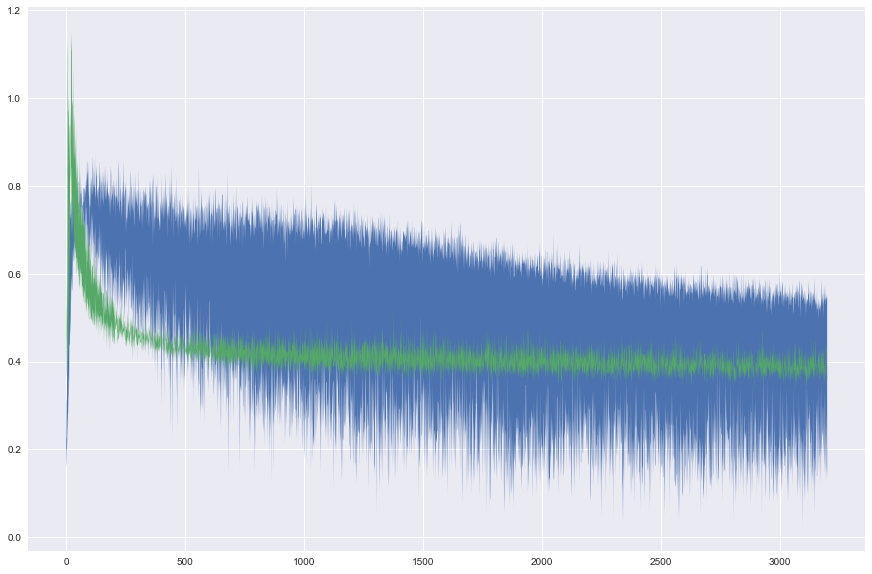

In [34]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_no_layer_curve) // 5 + 1), min_no_layer_curve[::5], max_no_layer_curve[::5])
plt.fill_between(range(len(min_layer_curve) // 5 + 1), min_layer_curve[::5], max_layer_curve[::5])
plt.show()

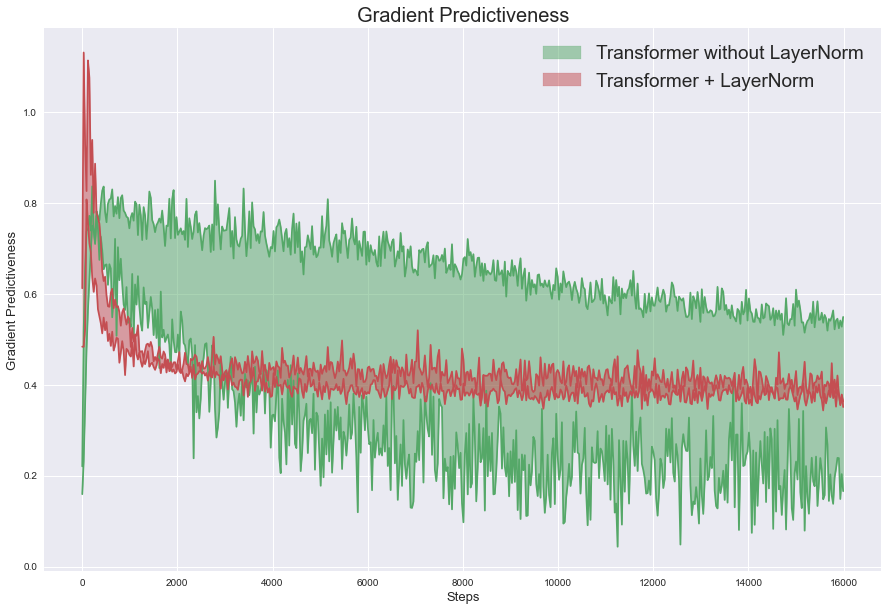

In [40]:
plt.show()
step = 30
steps = np.arange(0, len(min_no_layer_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_no_layer_curve[::step], max_no_layer_curve[::step],
                 alpha=0.5, color='C1', label='Transformer without LayerNorm')
plt.plot(steps, min_no_layer_curve[::step], color='C1')
plt.plot(steps, max_no_layer_curve[::step], color='C1')


plt.fill_between(steps, min_layer_curve[::step], max_layer_curve[::step],
                 alpha=0.5, color='C2', label='Transformer + LayerNorm')
plt.plot(steps, min_layer_curve[::step], color='C2')
plt.plot(steps, max_layer_curve[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
plt.ylabel('Gradient Predictiveness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig('Transformer_gradient_predictiveness.png', dpi=500, quality=100)
plt.show()

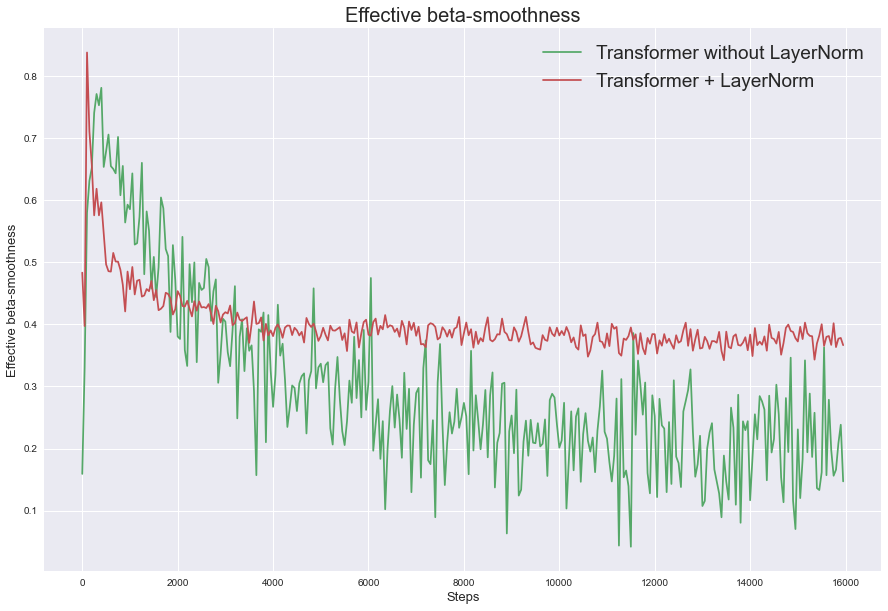

In [41]:
step = 50
steps = np.arange(0, len(min_no_layer_curve), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, min_no_layer_curve[::step], color='C1', label='Transformer without LayerNorm')

plt.plot(steps, min_layer_curve[::step], color='C2', label='Transformer + LayerNorm')
plt.legend(fontsize=19)
plt.title('Effective beta-smoothness', fontsize=20)
plt.ylabel('Effective beta-smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig('Transformer_effective_beta_smoothness.png', dpi=500, quality=100)
plt.show()

In [ ]:
for key in training_results:
    curr_result = training_results[key]

    plt.plot(curr_result[1], label = key)
plt.legend()
plt.show()

In [ ]:
translation, dec_attention_weight_seq = predict_seq2seq(model, "when you think about it", input_vocab, target_vocab
                                                        , 5, device, True)
print(translation)